In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pylab as plt
import config as cf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from chinese_calendar import is_workday, is_holiday
from jupyterthemes import jtplot

jtplot.style()
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 200

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [166]:
train_fix_df = pd.read_csv(cf.train_fix_file_path)
fs_train_df = pd.read_csv(cf.fusai_train_file_path, sep='\t')
# A
fs_testA_df = pd.read_csv(cf.fusai_testA_file_path, sep='\t')
# B
fs_testB_df = pd.read_csv(cf.fusai_testB_file_path, sep='\t')
# A answer
fs_trainA_df = pd.read_csv(cf.fusai_answerA_file_path, sep='\t', header=None, names=['date','brand','cnt'])
fs_trainA_df = fs_testA_df.merge(fs_trainA_df)

fs_train_df = fs_train_df.append(fs_trainA_df)
# fs_test_df = fs_testA_df
fs_test_df = fs_testB_df

# B predict at 0225 by arima.ipynb
predict_fix_df = pd.read_csv('test_fix_0225.csv')
predict_fix_df = predict_fix_df.rename(columns={'predict':'cnt'})

# convert to datetime
train_fix_df.loc[:,'date_fix'] = pd.to_datetime(train_fix_df['date_fix'])
predict_fix_df.loc[:,'date_fix'] = pd.to_datetime(predict_fix_df['date_fix'])

# normalize
train_fix_df = train_fix_df.drop(['Unnamed: 0'], axis=1)
predict_fix_df.loc[:,'month'] = predict_fix_df.loc[:, 'date_fix'].map(lambda x: datetime(x.year,x.month,1))

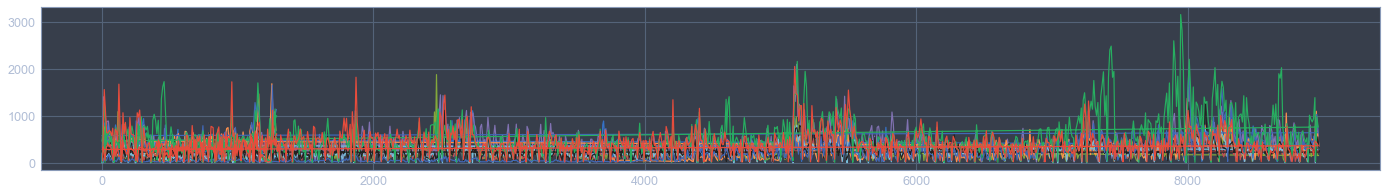

In [37]:
f = plt.figure(figsize=(24,3))
ax1 = f.add_subplot(111)
fs_train_brand_df = fs_train_df.groupby('brand', as_index=False)
for frame in fs_train_brand_df:
    frame[1].loc[:,"cnt"].plot(ax = ax1)

In [38]:
def fix_data_date(df, last_dow, start_date):
    fix_rows = []
    fix_date = 0
    fix_columns = np.append(df.columns.values, 'date_fix')
    is_train = 'cnt' in fix_columns
    for i, row in df.iterrows():
        curr_dow = row['day_of_week']
        while curr_dow - last_dow > 1 or -6 < curr_dow - last_dow <= 0:
            last_dow = last_dow + 1 if last_dow < 7 else 1
            fix_date += 1
            if is_train:
                fix_rows.append(np.array([-1, 0, last_dow, start_date + timedelta(days=fix_date)]))
            else:
                fix_rows.append(np.array([-1, last_dow, start_date + timedelta(days=fix_date)]))
        last_dow = curr_dow
        fix_date += 1
        fix_rows.append(np.append(row.values, start_date + timedelta(days=fix_date)))
    new_df = pd.DataFrame(fix_rows, columns=fix_columns)
    return new_df

# process train date
start_train_date = datetime(2012,12,31)
fs_train_cnt_df = fs_train_df.groupby('date', as_index=False)['cnt'].sum()
fs_train_cnt_df = fs_train_cnt_df.merge(fs_train_df[['date', 'day_of_week']].drop_duplicates(), on='date')
fs_train_new_df = fix_data_date(fs_train_cnt_df, 1, start_train_date)
# process test date
start_test_date = fs_train_new_df.iloc[-1,-1] - timedelta(days=1)
last_dow = fs_train_new_df.iloc[-1,-2] - 1
fs_test_cnt_df = fs_test_df[['date', 'day_of_week']].drop_duplicates()
fs_test_new_df = fix_data_date(fs_test_cnt_df, last_dow, start_test_date)
# process answer date
fs_trainA_cnt_df = fs_trainA_df.groupby('date', as_index=False)['cnt'].sum()
fs_trainA_cnt_df = fs_trainA_cnt_df.merge(fs_trainA_df[['date', 'day_of_week']].drop_duplicates(), on='date')

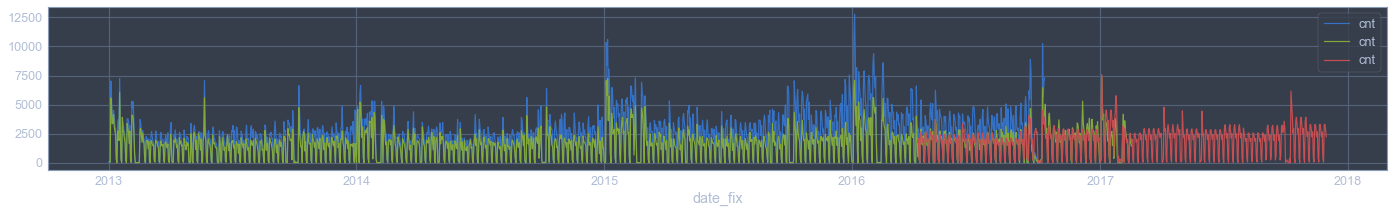

In [130]:
fs_train_new_df.to_csv(cf.fusai_train_fix_file_path)

f = plt.figure(figsize=(24,3))
ax1 = f.add_subplot(111)
fs_train_new_df[['date_fix', 'cnt']].set_index('date_fix').plot(ax=ax1)
train_fix_df[['date_fix', 'cnt']].set_index('date_fix').plot(ax=ax1)
predict_fix_df[['date_fix','cnt']].set_index('date_fix').plot(ax=ax1)

In [131]:
start_date = '2016-07-11'
end_date = '2016-10-12'
fs = fs_train_new_df.loc[fs_train_new_df['date_fix'] > start_date].sum()['cnt']
cs = train_fix_df.loc[(train_fix_df['date_fix'] > start_date) & (train_fix_df['date_fix'] < end_date)].sum()['cnt']
factor = float(fs) / cs
factor

1.698387591614113

In [132]:
start_date_num = fs_train_new_df.loc[fs_train_new_df['date_fix'] == start_date]
start_date_num = start_date_num.iloc[0][0]
print start_date_num

brand_factors = fs_train_df.loc[fs_train_df['date'] > start_date_num].groupby('brand', as_index=False).sum()[['brand', 'cnt']]
brand_factors.loc[:,'factor'] = brand_factors.loc[:,'cnt'] / fs
brand_factors

1168


,brand,cnt,factor
0,1,21726,0.087214
1,2,17944,0.072032
2,3,19072,0.076560
3,4,24671,0.099036
4,5,33809,0.135719
5,6,19976,0.080189
6,7,22066,0.088579
7,8,33519,0.134554
8,9,33748,0.135474
9,10,22580,0.090642


In [168]:
# merge predict result 0225
predict_base_df = train_fix_df.append(predict_fix_df.loc[predict_fix_df['date_fix'] > train_fix_df.iloc[-1,3]])
# cnt
fs_test_new_df.loc[:,'date_fix'] = fs_test_new_df.loc[:,'date_fix'].astype(str)
predict_base_df.loc[:,'date_fix'] = predict_base_df.loc[:,'date_fix'].astype(str)
fs_test_cnt_df = fs_test_new_df.merge(predict_base_df[['date_fix', 'cnt']], how='left', on='date_fix')
fs_test_cnt_df.loc[:, 'cnt'] = fs_test_cnt_df.loc[:, 'cnt'] * factor
# brand cnt
fs_test_ret_df = fs_test_df.merge(fs_test_cnt_df[['date', 'cnt']], how='left', on='date')
fs_test_ret_df = fs_test_ret_df.merge(brand_factors[['brand', 'factor']], how='left', on='brand')
fs_test_ret_df.loc[:, 'predict'] = fs_test_ret_df.loc[:, 'cnt'] * fs_test_ret_df.loc[:, 'factor'] 

In [169]:
fs_test_ret_df.to_csv('fs_test_fix.csv')
fs_test_ret_df[['date', 'brand', 'predict']].astype(int).to_csv('fs_test.csv', sep='\t', index=False, header=False)